Notebook purpose

- Perform entire analysis

In [15]:
import contextlib
import os
import re
import sys

import linearmodels as lm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import s3fs
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import tabulate

sys.path.append("/Users/fgu/dev/projects/entropy")
import entropy.data.cleaners as cl
import entropy.data.creators as cr
import entropy.data.selectors as sl
import entropy.figures.figures as figs
import entropy.helpers.aws as ha
import entropy.helpers.data as hd
import entropy.helpers.helpers as hh
from entropy import config

sns.set_style("whitegrid")
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)
pd.set_option("max_colwidth", None)
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

fs = s3fs.S3FileSystem(profile="3di")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
df = hd.read_analysis_data()
hd.inspect(df)

Time for read_analysis_data: 2.72 seconds
(163,915, 23)


obs  balance_ca  balance_sa  sa_inflows  sa_outflows  \
user_id date                                                               
57      2012-04-30   66         0.0         NaN         NaN          NaN   
        2012-05-31   75         0.0         NaN         NaN          NaN   

                    sa_net_inflows  sa_scaled_inflows  sa_scaled_outflows  \
user_id date                                                                
57      2012-04-30             NaN                NaN                 NaN   
        2012-05-31             NaN                NaN                 NaN   

                    sa_scaled_net_inflows  total_monthly_spend  \
user_id date                                                     
57      2012-04-30                    NaN             6.784095   
        2012-05-31                    NaN             6.837290   

                    tag_spend_household  tag_spend_hobbies  tag_spend_retail  \
user_id date                                                                   
57      2012-04-30             0.400869           0.011305           0.00937   
        2012-05-31             0.469773           0.010719           0.00000   

                    tag_spend_services  tag_spend_other_spend  \
user_id date                                                    
57      2012-04-30            0.245824               0.067898   
        2012-05-31            0.317825              -0.014239   

                    tag_spend_finance  tag_spend_travel  \
user_id date                                              
57      2012-04-30           0.000837          0.228929   
        2012-05-31           0.001105          0.148343   

                    tag_spend_communication  tag_spend_motor  entropy_sptac  \
user_id date                                                                  
57      2012-04-30                 0.034967              0.0       2.425209   
        2012-05-31                 0.066473              0.0       2.363752   

                    log_income  user_female   age  
user_id date                                       
57      2012-04-30   10.023162          0.0  25.0  
        2012-05-31   10.023162          0.0  25.0

## Sample description

## Sample summary statistics

In [29]:
import entropy.analysis.sumstats_table as eas

eas.main(df, write=False)

,count,mean,std,min,max,25%,50%,75%
obs,163915.0,98.068859,51.257414,11.000000,656.000000,63.000000,89.000000,123.000000
balance_ca,159116.0,1130.199463,4834.210938,-12257.117188,34628.589844,-884.007996,81.886841,1395.455078
balance_sa,64935.0,2625.156006,5496.725586,-1644.621460,42168.609375,2.210007,457.499939,2500.000000
sa_inflows,60583.0,780.843750,1507.547729,0.000000,13800.000000,60.000000,251.000000,790.385010
sa_outflows,60583.0,749.975220,1452.101318,0.000000,12075.480469,0.000000,200.000000,800.000000
sa_net_inflows,61195.0,75.746101,3330.151123,-69750.000000,120000.000000,-180.000000,17.700001,256.000000
sa_scaled_inflows,59977.0,0.335841,0.548266,0.000000,4.137818,0.031901,0.134704,0.383184
sa_scaled_outflows,59977.0,0.332819,0.576240,0.000000,4.039455,0.000000,0.105145,0.392159
sa_scaled_net_inflows,59971.0,0.007137,0.614697,-4.034811,4.184336,-0.084530,0.008627,0.133873
total_monthly_spend,156510.0,7.281420,0.728324,4.954418,9.161083,6.816706,7.300010,7.781670


## Bivariate plots

In [152]:
data["entropy_pct"] = data.entropy_sptac.rank(pct=True)

In [41]:
def make_data(df, col_name, **trim_kws):
    return (
        df.set_index("entropy_sptac", append=True)
        .loc[:, col_name]
        .rename("value")
        .reset_index("entropy_sptac")
    )


def make_plot(df, axis):
    sns.regplot(
        data=df,
        y="value",
        x="entropy_sptac",
        order=3,
        x_bins=20,
        x_ci=None,
        ci=95,
        ax=ax[axis],
    )

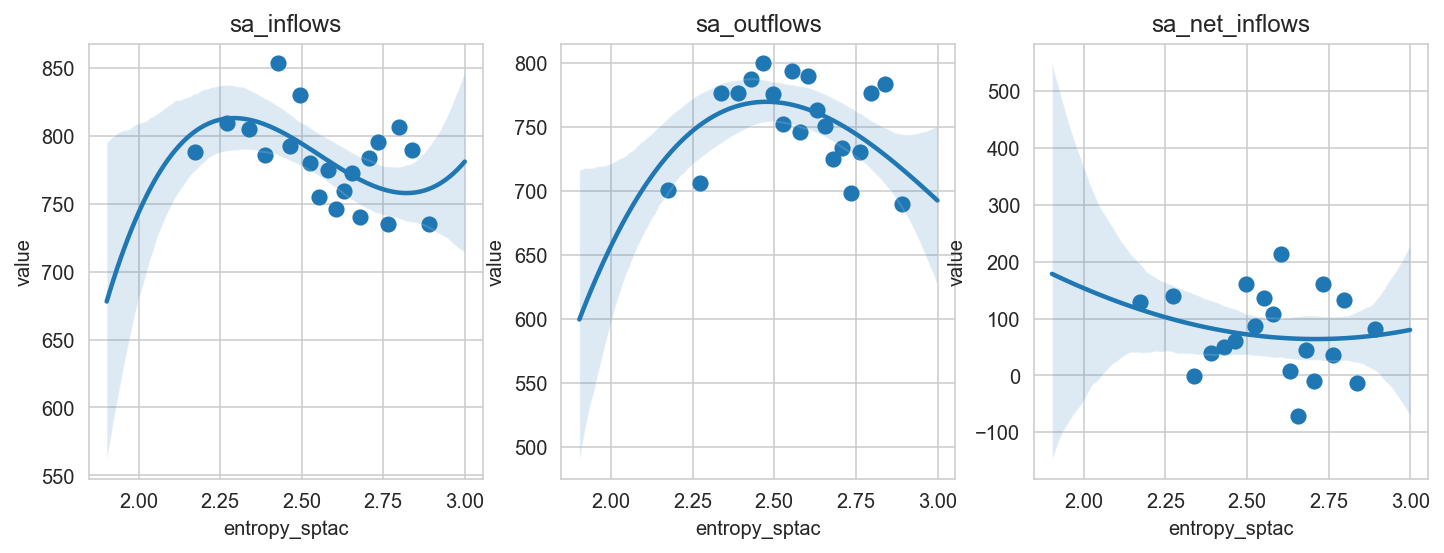

In [44]:
pattern = "sa_[oin]"
outcome_vars = hd.colname_subset(data, pattern)
num_vars = len(outcome_vars)
fig, ax = plt.subplots(1, num_vars, figsize=(4 * num_vars, 4))
for idx, var in enumerate(outcome_vars):
    d = make_data(data, col_name=var)
    make_plot(d, idx)
    ax[idx].set_title(var)

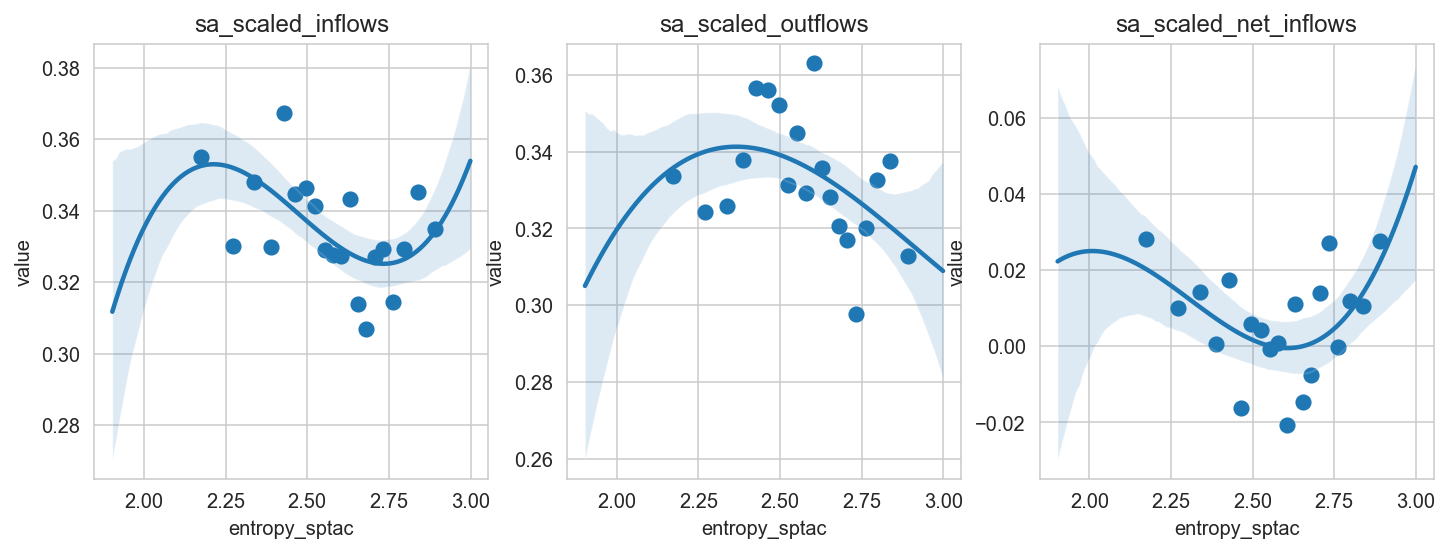

In [45]:
pattern = "sa_scaled"
outcome_vars = hd.colname_subset(data, pattern)
num_vars = len(outcome_vars)
fig, ax = plt.subplots(1, num_vars, figsize=(4 * num_vars, 4))
for idx, var in enumerate(outcome_vars):
    d = make_data(data, col_name=var)
    make_plot(d, idx)
    ax[idx].set_title(var)

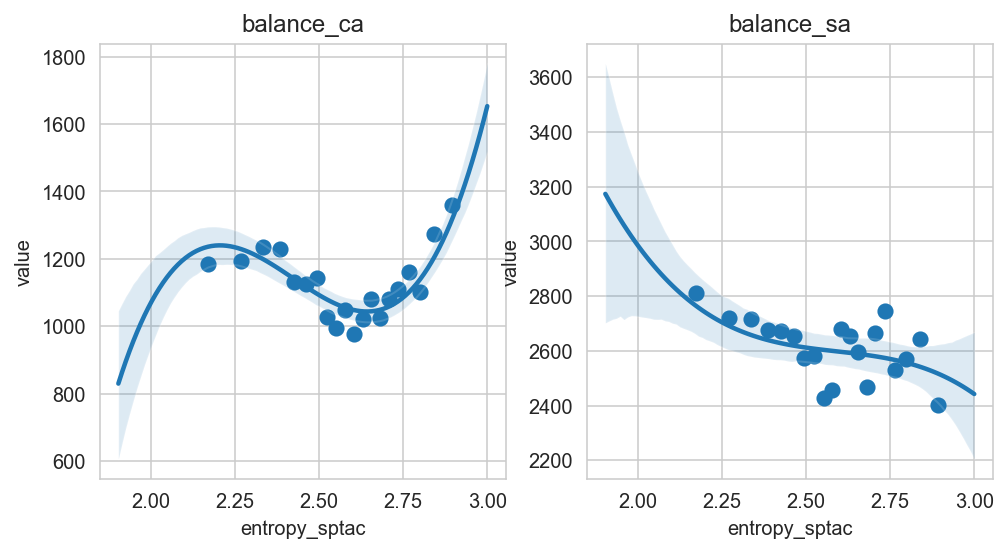

In [42]:
pattern = "balance_"
outcome_vars = hd.colname_subset(data, pattern)
num_vars = len(outcome_vars)
fig, ax = plt.subplots(1, num_vars, figsize=(4 * num_vars, 4))
for idx, var in enumerate(outcome_vars):
    d = make_data(data, col_name=var)
    make_plot(d, idx)
    ax[idx].set_title(var)

## Main results

## Fixed effects

In [53]:
y = data["sa_inflows"]
tag_spend = hd.colname_subset(data, "tag_spend")[:-1]
full_controls = ["log_income", "total_monthly_spend"] + tag_spend[:-1]


b = lm.PanelOLS(
    y,
    data["entropy_sptac"],
    entity_effects=True,
    time_effects=True,
).fit()
ba = lm.PanelOLS(
    y,
    data[["entropy_sptac", "log_income"]],
    entity_effects=True,
    time_effects=True,
).fit()
bd = lm.PanelOLS(
    y,
    data[["entropy_sptac", "total_monthly_spend"]],
    entity_effects=True,
    time_effects=True,
).fit()
be = lm.PanelOLS(
    y,
    data[["entropy_sptac"] + tag_spend[:-1]],
    entity_effects=True,
    time_effects=True,
).fit()
bf = lm.PanelOLS(
    y,
    data[["entropy_sptac"] + full_controls],
    entity_effects=True,
    time_effects=True,
).fit()
bg = lm.PanelOLS(
    y,
    data[["entropy_sptac"] + full_controls],
    entity_effects=True,
    time_effects=True,
).fit(cov_type="clustered", cluster_entity=True)
bh = lm.PanelOLS(
    y,
    data[["entropy_sptac"] + full_controls],
    entity_effects=True,
    time_effects=False,
).fit(cov_type="clustered", cluster_entity=True)
bi = lm.PanelOLS(
    y,
    data[["entropy_sptac"] + full_controls],
    entity_effects=False,
    time_effects=True,
).fit(cov_type="clustered", cluster_entity=True)
bj = lm.PanelOLS(
    y,
    data[["entropy_sptac"] + full_controls],
    entity_effects=False,
    time_effects=False,
).fit(cov_type="clustered", cluster_entity=True)


lm.panel.compare([b, ba, bd, be, bf, bg, bh, bi, bj], stars=True)

/Users/fgu/miniconda3/envs/entropy/lib/python3.9/site-packages/linearmodels/shared/exceptions.py:35: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)
/Users/fgu/miniconda3/envs/entropy/lib/python3.9/site-packages/linearmodels/shared/exceptions.py:35: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)
/Users/fgu/miniconda3/envs/entropy/lib/python3.9/site-packages/linearmodels/shared/exceptions.py:35: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)
/Users/fgu/miniconda3/envs/entropy/lib/python3.9/site-packages/linearmodels/shared/exceptions.py:35: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_valu

,Model 0,Model 1,Model 2,Model 3,Model 4,Model 5,Model 6,Model 7,Model 8
Dep. Variable,sa_inflows,sa_inflows,sa_inflows,sa_inflows,sa_inflows,sa_inflows,sa_inflows,sa_inflows,sa_inflows
Estimator,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS
No. Observations,59495,59495,56959,55512,54690,54690,54690,54690,54690
Cov. Est.,Unadjusted,Unadjusted,Unadjusted,Unadjusted,Unadjusted,Clustered,Clustered,Clustered,Clustered
R-squared,6.465e-05,0.0013,0.0012,0.0006,0.0036,0.0036,0.0039,0.0302,0.2274
R-Squared (Within),8.723e-05,0.0015,0.0013,0.0006,0.0039,0.0039,0.0039,0.0009,-0.0005
R-Squared (Between),-0.2207,-0.6461,0.3969,-0.0890,-2.6600,-2.6600,-2.8361,-9.9136,0.4288
R-Squared (Overall),-0.1085,-0.2563,0.2046,-0.0444,-1.2523,-1.2523,-1.3377,-4.7859,0.2274
F-statistic,3.6040,37.283,30.798,3.8078,18.451,18.451,19.975,169.74,1609.3
P-value (F-stat),0.0576,0.0000,0.0000,0.0002,0.0000,0.0000,0.0000,0.0000,0.0000


## Pooled regressions

In [48]:
full_controls = ["log_income", "age", "user_female", "total_monthly_spend"] + tag_spend

a = lm.PanelOLS(y, sm.add_constant(data["entropy_sptac"])).fit()
aa = lm.PanelOLS(y, sm.add_constant(data[["entropy_sptac", "log_income"]])).fit()
ab = lm.PanelOLS(y, sm.add_constant(data[["entropy_sptac", "age"]])).fit()
ac = lm.PanelOLS(y, sm.add_constant(data[["entropy_sptac", "user_female"]])).fit()
ad = lm.PanelOLS(
    y, sm.add_constant(data[["entropy_sptac", "total_monthly_spend"]])
).fit()
ae = lm.PanelOLS(y, sm.add_constant(data[["entropy_sptac"] + tag_spend[:-1]])).fit()
af = lm.PanelOLS(y, sm.add_constant(data[["entropy_sptac"] + full_controls])).fit()
ag = lm.PanelOLS(y, sm.add_constant(data[["entropy_sptac"] + full_controls])).fit(
    cov_type="clustered", cluster_entity=True
)


lm.panel.compare([a, aa, ab, ac, ad, ae, af, ag], stars=True)

/Users/fgu/miniconda3/envs/entropy/lib/python3.9/site-packages/linearmodels/shared/exceptions.py:35: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)
/Users/fgu/miniconda3/envs/entropy/lib/python3.9/site-packages/linearmodels/panel/results.py:1010: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  vals = concat(


,Model 0,Model 1,Model 2,Model 3,Model 4,Model 5,Model 6,Model 7
Dep. Variable,sa_inflows,sa_inflows,sa_inflows,sa_inflows,sa_inflows,sa_inflows,sa_inflows,sa_inflows
Estimator,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS
No. Observations,59495,59495,53783,56609,56959,55512,46825,46825
Cov. Est.,Unadjusted,Unadjusted,Unadjusted,Unadjusted,Unadjusted,Unadjusted,Unadjusted,Clustered
R-squared,7.581e-05,0.0181,0.0039,0.0036,0.0172,0.0056,0.0329,0.0329
R-Squared (Within),8.388e-05,0.0009,0.0001,6.38e-05,-0.0025,-0.0029,0.0011,0.0011
R-Squared (Between),-0.0018,0.0397,0.0066,0.0075,0.0428,0.0165,0.0783,0.0783
R-Squared (Overall),7.581e-05,0.0181,0.0039,0.0036,0.0172,0.0056,0.0329,0.0329
F-statistic,4.5104,549.70,104.89,101.66,499.84,39.325,122.39,122.39
P-value (F-stat),0.0337,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
